# USD/RUB exchange rate analysis

In [1]:
import itertools
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings
warnings.filterwarnings("ignore")

sns.set()
%matplotlib inline

In [2]:
df = pd.read_excel("data/RC_F01_01_1998_T01_05_2020.xlsx", index_col="data")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5545 entries, 1998-01-01 to 2020-05-01
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   nominal  5545 non-null   int64  
 1   curs     5545 non-null   float64
 2   cdx      5545 non-null   object 
dtypes: float64(1), int64(1), object(1)
memory usage: 173.3+ KB


In [4]:
df.head()

,nominal,curs,cdx
data,,,
1998-01-01,1,5.960,Доллар США
1998-01-06,1,5.963,Доллар США
1998-01-07,1,5.969,Доллар США
1998-01-09,1,5.972,Доллар США
1998-01-10,1,5.974,Доллар США


In [5]:
df = df[["curs"]]

In [6]:
df = df[df.index > "2012-01-01"]

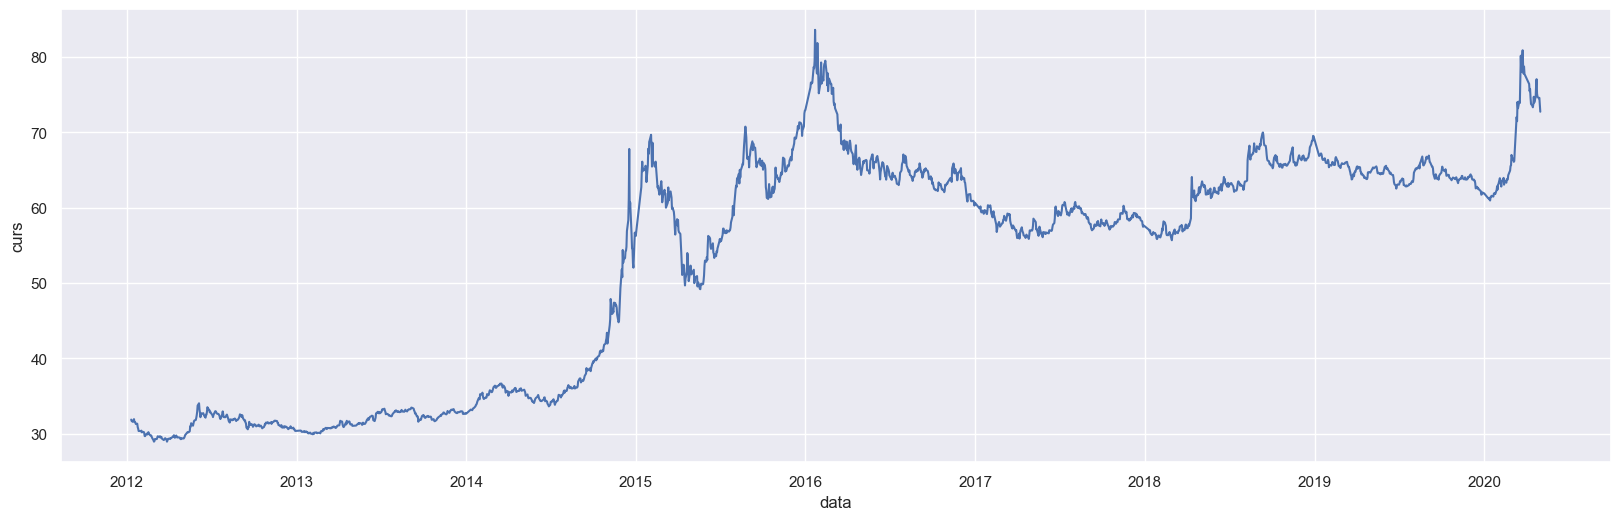

In [7]:
fig, ax = plt.subplots(figsize=(20, 6), dpi=100)
sns.lineplot(x=df.index, y=df.curs);

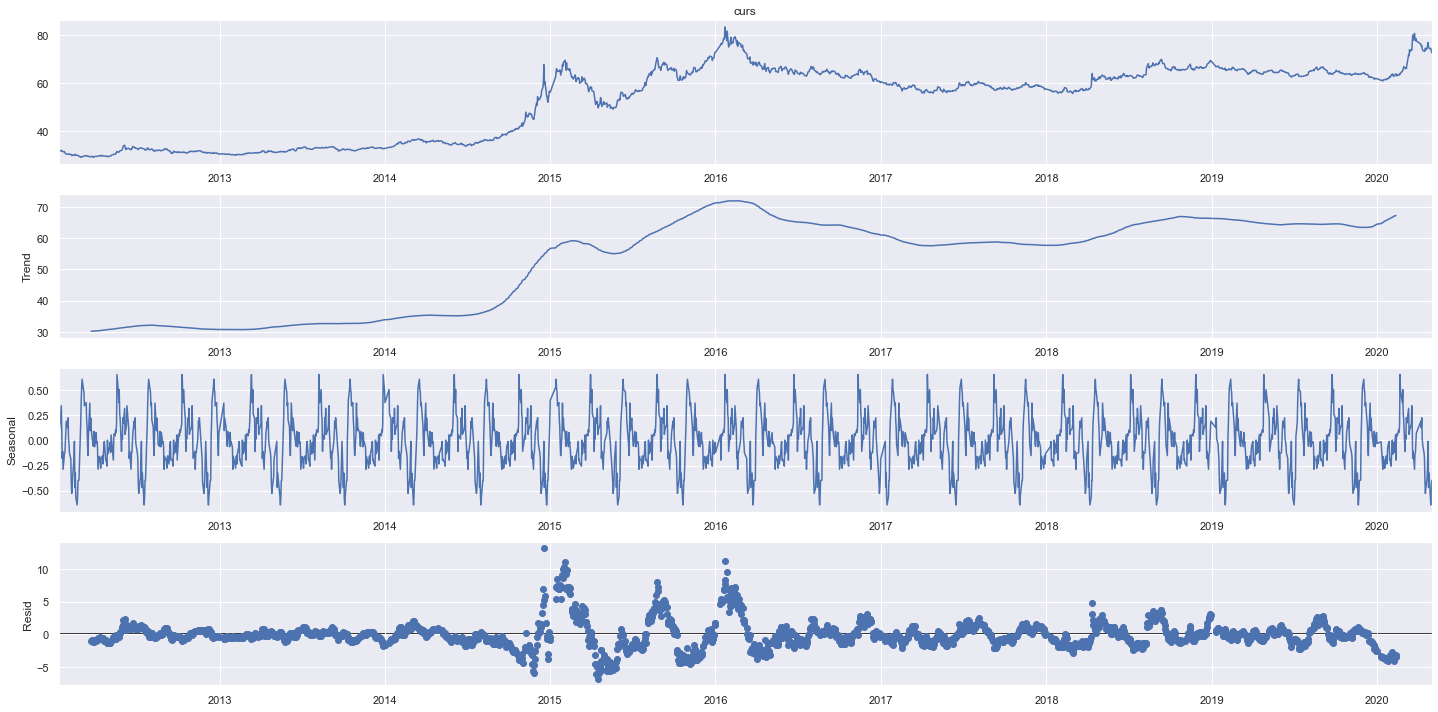

In [8]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10
decomposition = sm.tsa.seasonal_decompose(df.curs, model='additive', period=101)
fig = decomposition.plot()
plt.show()

In [9]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

# print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
# print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
# print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
# print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

In [10]:
# for param in pdq:
#     for param_seasonal in seasonal_pdq:
#         try:
#             mod = sm.tsa.statespace.SARIMAX(
#                 df.curs,
#                 order=param,
#                 seasonal_order=param_seasonal,
#                 enforce_stationarity=False,
#                 enforce_invertibility=False,
#             )
#             results = mod.fit()
#             print("ARIMA{}x{}12 - AIC:{}".format(param, param_seasonal, results.aic))
#         except:
#             continue

In [11]:
mod = sm.tsa.statespace.SARIMAX(df,
                                order=(0, 1, 0),
                                seasonal_order=(0, 0, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                 curs   No. Observations:                 2052
Model:             SARIMAX(0, 1, 0)x(0, 0, [1], 12)   Log Likelihood               -2130.919
Date:                              Tue, 12 Jul 2022   AIC                           4265.838
Time:                                      23:10:05   BIC                           4277.077
Sample:                                           0   HQIC                          4269.961
                                             - 2052                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12       0.0392      0.012      3.154      0.002       0.015       0.063
sigma2         0.47

In [12]:
# plot_acf(df.curs);

In [13]:
# plot_pacf(df.curs);

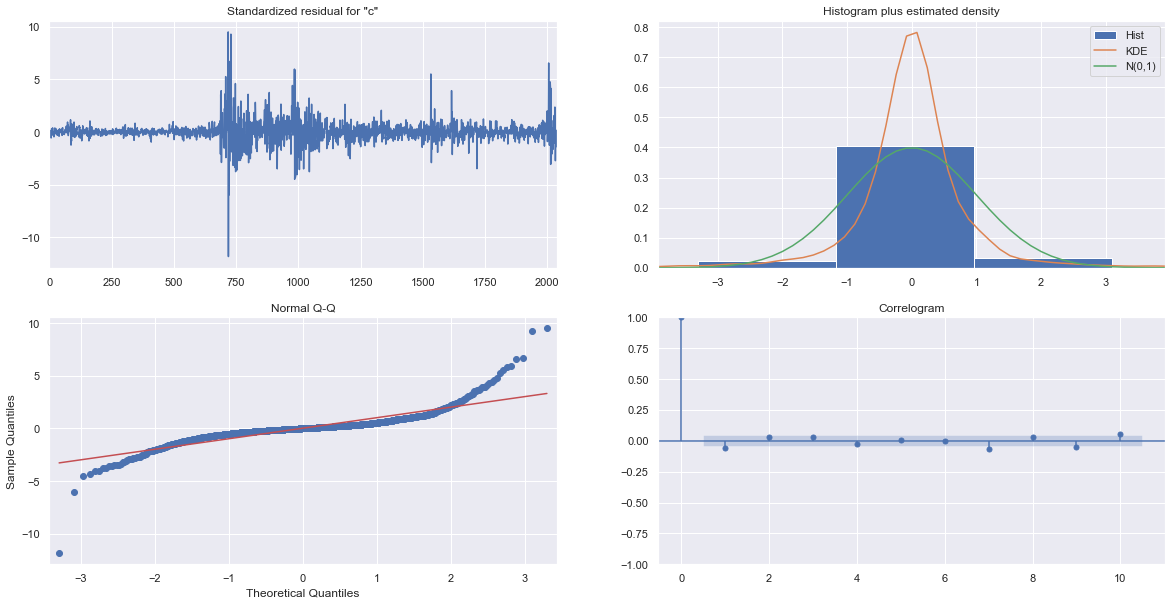

In [14]:
results.plot_diagnostics(figsize=(20, 10))
plt.show()

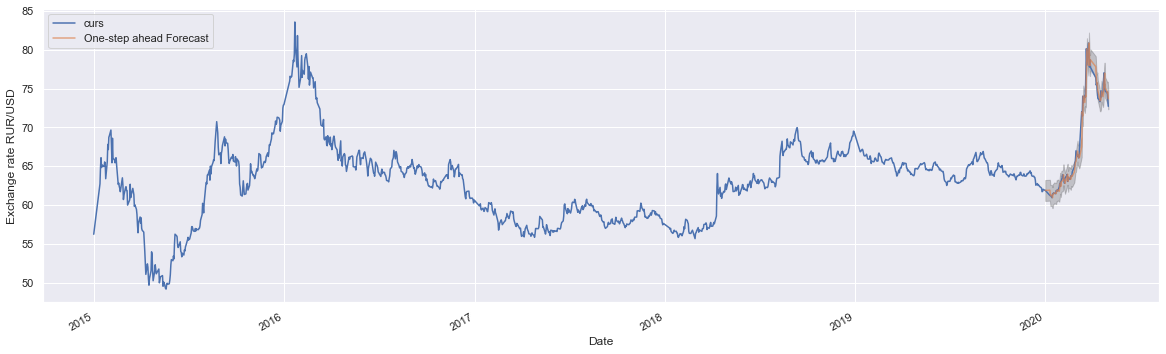

In [15]:
pred = results.get_prediction(start=pd.to_datetime('2020-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = df['2015':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(20, 6))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Exchange rate RUR/USD')
plt.legend()
plt.show()

In [16]:
y_forecasted = pred.predicted_mean
y_forecasted = y_forecasted.to_frame(name="predicted")
y_truth = df['2020-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()

In [17]:
# print('The Mean Squared Error is {}'.format(round(mse, 2)))
# print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))

In [18]:
y_temp = y_truth.merge(y_forecasted, how="left", left_index=True, right_index=True)

In [19]:
y_temp

,curs,predicted
data,,
2020-01-01,61.9057,61.879506
2020-01-10,61.2340,61.913886
2020-01-11,61.2632,61.224809
2020-01-14,60.9474,61.264675
2020-01-15,61.4140,60.945648
...,...,...
2020-04-25,74.7163,75.139143
2020-04-28,74.4960,74.671841
2020-04-29,74.5706,74.457571


In [20]:
pred2HY202 = results.forecast(12, dynamic=False)

In [21]:
pred2HY202.values

array([72.7375707 , 72.77974401, 72.75138078, 72.77847925, 72.84223632,
       72.87517045, 72.80169454, 72.78513898, 72.77825427, 72.78267971,
       72.74870423, 72.7111901 ])